# Hypothesis Testing with Insurance Data (Core)
For this assignment, we will be working with the US Health Insurance Dataset from Kaggle.

We have been asked to use our hypothesis testing skills to answer the following questions:

- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

In [85]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

In [86]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### 1. Do smokers have higher insurance charges than non-smokers?

In [88]:
df['smoker'].unique

<bound method Series.unique of 0       yes
1        no
2        no
3        no
4        no
       ... 
1333     no
1334     no
1335     no
1336     no
1337    yes
Name: smoker, Length: 1338, dtype: object>

In [89]:
smoker_charges = df.loc[df['smoker']=='yes', ['charges', 'smoker']]
smoker_charges

,charges,smoker
0,16884.92400,yes
11,27808.72510,yes
14,39611.75770,yes
19,36837.46700,yes
23,37701.87680,yes
...,...,...
1313,36397.57600,yes
1314,18765.87545,yes
1321,28101.33305,yes
1323,43896.37630,yes


In [90]:
nonsmoker_charges = df.loc[df['smoker']=='no', ['charges', 'smoker']]
nonsmoker_charges

,charges,smoker
1,1725.55230,no
2,4449.46200,no
3,21984.47061,no
4,3866.85520,no
5,3756.62160,no
...,...,...
1332,11411.68500,no
1333,10600.54830,no
1334,2205.98080,no
1335,1629.83350,no


In [91]:
print(f"{len(smoker_charges)} smokers insurance charges." )
print(f"{len(nonsmoker_charges)} non smokers insurance charges." )

274 smokers insurance charges.
1064 non smokers insurance charges.


In [92]:
plot_df = pd.concat([smoker_charges, nonsmoker_charges], axis=0)
plot_df

,charges,smoker
0,16884.9240,yes
11,27808.7251,yes
14,39611.7577,yes
19,36837.4670,yes
23,37701.8768,yes
...,...,...
1332,11411.6850,no
1333,10600.5483,no
1334,2205.9808,no
1335,1629.8335,no


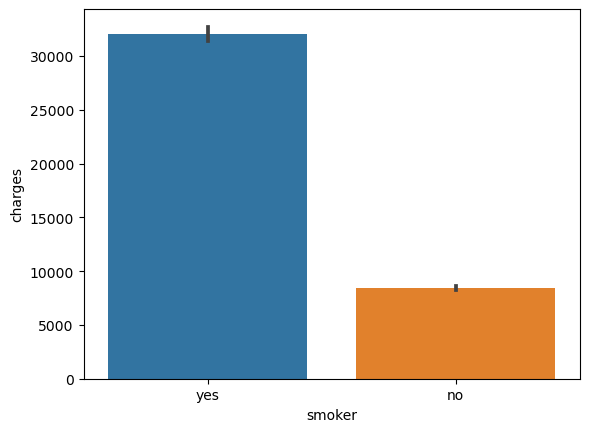

In [93]:
## visualizing means. ci=68 makes easier to compare error bars (will discuss in class)
ax = sns.barplot(data=plot_df, x='smoker', y='charges', errorbar=('ci', 68))

In [94]:
## now that we have visualized the groups, we can save a final male_group and female_group
# that are a pandas Series. This will make the rest of our workflow simpler than if 
# we still had a dataframe

smoker_group = smoker_charges['charges']
nonsmoker_group = nonsmoker_charges['charges']
display(smoker_group.head(), nonsmoker_group.head())

0     16884.9240
11    27808.7251
14    39611.7577
19    36837.4670
23    37701.8768
Name: charges, dtype: float64

1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
5     3756.62160
Name: charges, dtype: float64

In [95]:
## Checking for abs vlaue of z-scores that are > 3
is_outlier_smokers = np.abs(stats.zscore(smoker_group)) > 3
print(f"There are {is_outlier_smokers.sum()} outliers in the smoker group out of {len(smoker_group)})")

There are 0 outliers in the smoker group out of 274)


In [96]:
## Checking for abs vlaue of z-scores that are > 3
is_outlier_nonsmokers = np.abs(stats.zscore(nonsmoker_group)) > 3
print(f"There are {is_outlier_nonsmokers.sum()} outliers in the male group of out of {len(nonsmoker_group)}.")

There are 24 outliers in the male group of out of 1064.


In [97]:
## removing outliers from nonsmoker_group
nonsmoker_group = nonsmoker_group.loc[~is_outlier_nonsmokers]
nonsmoker_group

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1040, dtype: float64

In [98]:
result = stats.levene(smoker_group, nonsmoker_group)
print(result)
print(result.pvalue<.05)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)
True


In [99]:
result = stats.ttest_ind(smoker_group, nonsmoker_group, equal_var=False)
print(result)
result.pvalue < .05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


True

In [100]:
print(f"The average insurance charges for smoker group was {smoker_group.mean():.2f}")
print(f"The average insurance charges for non smoker group was {nonsmoker_group.mean():.2f}")

The average insurance charges for smoker group was 32050.23
The average insurance charges for non smoker group was 7939.86


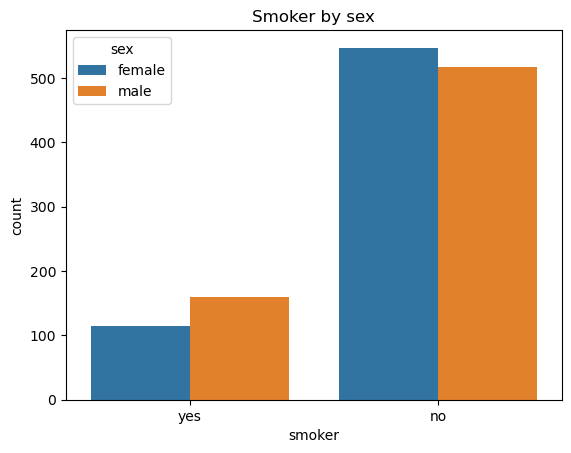

In [101]:
ax = sns.countplot(data=df, x='smoker', hue='sex')

# Add title to the plot
ax.set_title('Smoker by sex');

- The average insurance charges for smoker group was significantly higher than non smokers.

### 2. Are men more likely to smoke than women?

In [102]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [103]:
female_df = df.loc[df['sex']== 'female']

In [104]:
female_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92400
5,31,female,25.74,0,no,southeast,3756.62160
6,46,female,33.44,1,no,southeast,8240.58960
7,37,female,27.74,3,no,northwest,7281.50560
9,60,female,25.84,0,no,northwest,28923.13692
...,...,...,...,...,...,...,...
1332,52,female,44.70,3,no,southwest,11411.68500
1334,18,female,31.92,0,no,northeast,2205.98080
1335,18,female,36.85,0,no,southeast,1629.83350
1336,21,female,25.80,0,no,southwest,2007.94500


In [105]:
female_smoker = female_df.loc[female_df['smoker']=='yes']
female_smoker 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
11,62,female,26.290,0,yes,southeast,27808.72510
23,34,female,31.920,1,yes,northeast,37701.87680
58,53,female,22.880,1,yes,southeast,23244.79020
64,20,female,22.420,0,yes,northwest,14711.74380
...,...,...,...,...,...,...,...
1308,25,female,30.200,0,yes,southwest,33900.65300
1313,19,female,34.700,2,yes,southwest,36397.57600
1314,30,female,23.655,3,yes,northwest,18765.87545
1323,42,female,40.370,2,yes,southeast,43896.37630


In [106]:
male_df = df.loc[df['sex']== 'male']
male_df

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
8,37,male,29.830,2,no,northeast,6406.41070
...,...,...,...,...,...,...,...
1324,31,male,25.935,1,no,northwest,4239.89265
1325,61,male,33.535,0,no,northeast,13143.33665
1327,51,male,30.030,1,no,southeast,9377.90470
1329,52,male,38.600,2,no,southwest,10325.20600


In [107]:
male_smoker = male_df.loc[male_df['smoker']=='yes']
male_smoker 

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
34,28,male,36.400,1,yes,southwest,51194.55914
...,...,...,...,...,...,...,...
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1304,42,male,24.605,2,yes,northeast,21259.37795
1307,32,male,28.120,4,yes,northwest,21472.47880


In [108]:
print(f"There are {len(male_smoker)} male smokers.")
print(f"There are {len(female_smoker)} female smokers.")

There are 159 male smokers.
There are 115 female smokers.


### 3. Do different regions have different charges, on average?

In [109]:
## Create groups dictionary. 
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [110]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [111]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [112]:
# with the * operator 
result = stats.levene(*groups.values())
print(result)
print(result.pvalue<.05)

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)
True


In [113]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.kruskal( *groups.values())
print(result)
print(result.pvalue<.05)

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)
False


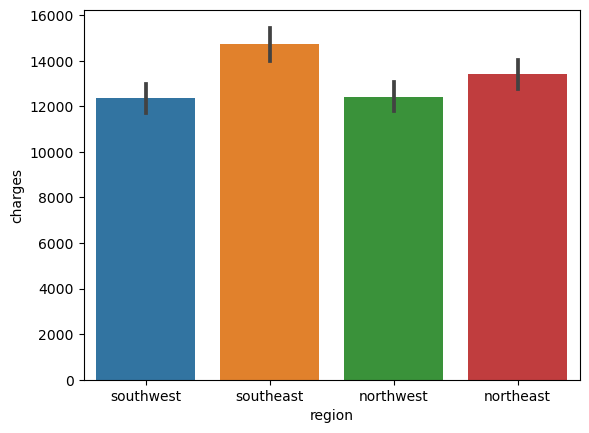

In [114]:
## visualizing means. ci=68 makes easier to compare error bars 
ax = sns.barplot(data=df, x='region', y='charges', errorbar=('ci', 68))